In [1]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [9]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [10]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/288 [00:00<?, ?it/s]

In [11]:
signal.size(), label.size()

(torch.Size([288, 22, 1, 1, 1001]), torch.Size([288]))

In [12]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [13]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [14]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

(torch.Size([288, 1001, 22]), torch.Size([22]))

In [15]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

torch.Size([288, 22, 1001])

In [16]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

torch.Size([22, 22])

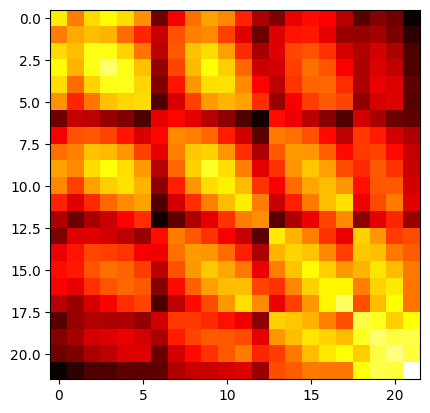

In [17]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [18]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

torch.Size([22, 22])

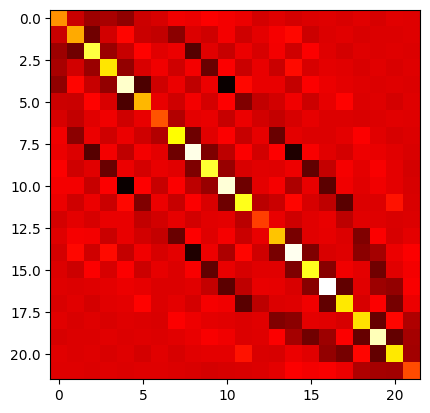

In [19]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [20]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

torch.Size([288, 22, 1001])

In [21]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

torch.Size([22, 22])

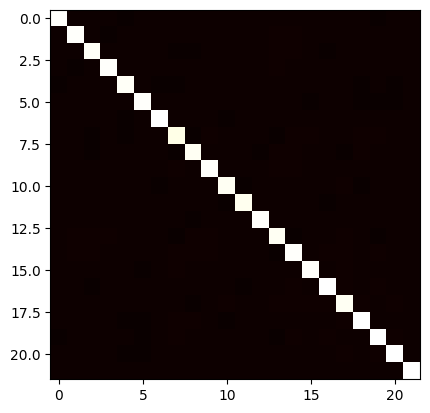

In [22]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [ ]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [27]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [28]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [29]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [30]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [51]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [33]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/2592 [00:00<?, ?it/s]

torch.Size([2592, 22, 1, 1, 1001])

In [34]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

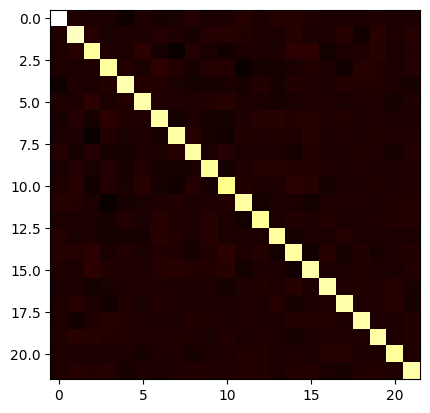

In [35]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [37]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [42]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [81]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        # CLS CNN
        conv2d_batch_out_channels_1 = 40

        self.conv2d_1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_1,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_1 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_1)

        self.activation = nn.ReLU()

        conv2d_batch_out_channels_2 = 40

        self.conv2d_2 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_2,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_2 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_2)

        self.flatten = nn.Flatten()

        drop_out_1 = 0.5
        self.drop_out_1 = nn.Dropout(p=drop_out_1)

        self.fc1 = nn.Linear(3520, 40)

        drop_out_2 = 0.5
        self.drop_out_2 = nn.Dropout(p=drop_out_2)

        self.fc2 = nn.Linear(40, 10)

        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        features = features.unsqueeze_(1)
        features = features.unsqueeze_(-1)

        # Cls CNN
        x = self.conv2d_1(features)
        x = self.batch_norm_1(x)
        x = self.activation(x)

        x = self.conv2d_2(features)
        x = self.batch_norm_2(x)
        x = self.activation(x)

        x = self.flatten(x)

        # print(f"{x.size() = }")

        x = self.drop_out_1(x)
        x = self.fc1(x)
        x = self.activation(x)

        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.activation(x)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [82]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [83]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


81it [00:02, 27.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3732022635730696


Train -  [0.40007716049382713, 0.20010288065843618, 0.6672114340420667, 0.40007716049382713, tensor(1.3389)]
Validation -  [0.4066358024691358, 0.20884773662551437, 0.6443058016435502, 0.40663580246913583, tensor(1.3381)]

Epoch  1


81it [00:02, 27.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3246893573690344


Train -  [0.4826388888888889, 0.31018518518518523, 0.7441802173830209, 0.4826388888888889, tensor(1.2595)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.7112460030546665, 0.4367283950617284, tensor(1.2807)]

Epoch  2


81it [00:02, 28.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2704849243164062


Train -  [0.5023148148148148, 0.3364197530864198, 0.7685222892216634, 0.5023148148148148, tensor(1.2178)]
Validation -  [0.4367283950617284, 0.2489711934156379, 0.715700394217091, 0.4367283950617284, tensor(1.2735)]

Epoch  3


81it [00:02, 31.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2463566521067677


Train -  [0.5567129629629629, 0.40895061728395066, 0.7977887009094142, 0.5567129629629629, tensor(1.1809)]
Validation -  [0.4683641975308642, 0.29115226337448563, 0.7364072105370115, 0.4683641975308643, tensor(1.2459)]

Epoch  4


81it [00:02, 32.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2256308014010207


Train -  [0.5667438271604939, 0.4223251028806584, 0.8178436817304272, 0.5667438271604939, tensor(1.1689)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.7445058870598994, 0.4498456790123457, tensor(1.2629)]

Epoch  5


81it [00:02, 32.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1994451711207261


Train -  [0.6192129629629629, 0.4922839506172839, 0.8409391392635777, 0.6192129629629629, tensor(1.1269)]
Validation -  [0.5003858024691358, 0.33384773662551437, 0.7591332383909973, 0.5003858024691358, tensor(1.2248)]

Epoch  6


81it [00:02, 29.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.175552977455987


Train -  [0.6520061728395061, 0.5360082304526749, 0.851191383427323, 0.6520061728395061, tensor(1.0992)]
Validation -  [0.527391975308642, 0.36985596707818935, 0.7684731708517503, 0.527391975308642, tensor(1.2049)]

Epoch  7


81it [00:02, 29.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1631744261141177


Train -  [0.6620370370370371, 0.5493827160493827, 0.8584696343291165, 0.6620370370370371, tensor(1.0836)]
Validation -  [0.53125, 0.375, 0.7736034109383733, 0.53125, tensor(1.2001)]

Epoch  8


81it [00:02, 33.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1612724551448115


Train -  [0.6315586419753086, 0.5087448559670782, 0.8607784954021238, 0.6315586419753086, tensor(1.1073)]
Validation -  [0.503858024691358, 0.338477366255144, 0.7731549949512271, 0.503858024691358, tensor(1.2234)]

Epoch  9


81it [00:02, 32.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1533793681933555


Train -  [0.6685956790123457, 0.5581275720164609, 0.8693852245592645, 0.6685956790123457, tensor(1.0775)]
Validation -  [0.5177469135802469, 0.3569958847736625, 0.7760383921086724, 0.5177469135802469, tensor(1.2091)]

Epoch  10


81it [00:02, 32.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1329249437944389


Train -  [0.6867283950617284, 0.5823045267489713, 0.8754556597063455, 0.6867283950617284, tensor(1.0582)]
Validation -  [0.5320216049382716, 0.3760288065843621, 0.7820392677056344, 0.5320216049382716, tensor(1.1948)]

Epoch  11


81it [00:02, 34.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1267548284412903


Train -  [0.6751543209876543, 0.5668724279835391, 0.8810152638063302, 0.6751543209876543, tensor(1.0614)]
Validation -  [0.5366512345679012, 0.382201646090535, 0.7889843075242595, 0.5366512345679012, tensor(1.1922)]

Epoch  12


81it [00:02, 34.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1081876269093267


Train -  [0.7013888888888888, 0.6018518518518519, 0.8841970426573694, 0.7013888888888888, tensor(1.0381)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.7822332604595337, 0.5439814814814815, tensor(1.1871)]

Epoch  13


81it [00:02, 33.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.101878903530262


Train -  [0.7037037037037037, 0.6049382716049383, 0.8878864772265407, 0.7037037037037037, tensor(1.0350)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7821698531092821, 0.5277777777777778, tensor(1.1989)]

Epoch  14


81it [00:02, 34.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.109147094650033


Train -  [0.7218364197530864, 0.6291152263374485, 0.8947746588109028, 0.7218364197530864, tensor(1.0239)]
Validation -  [0.5308641975308642, 0.3744855967078189, 0.7843756152199868, 0.5308641975308642, tensor(1.1958)]

Epoch  15


81it [00:03, 25.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.089791743107784


Train -  [0.6998456790123457, 0.5997942386831276, 0.8859525034293553, 0.6998456790123457, tensor(1.0370)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.7829242914253417, 0.5347222222222222, tensor(1.1962)]

Epoch  16


81it [00:02, 33.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.094844509789973


Train -  [0.7083333333333334, 0.6111111111111112, 0.8928291744462226, 0.7083333333333334, tensor(1.0297)]
Validation -  [0.5339506172839507, 0.37860082304526754, 0.7822621361073008, 0.5339506172839507, tensor(1.1959)]

Epoch  17


81it [00:02, 33.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0928253877310106


Train -  [0.7156635802469136, 0.6208847736625515, 0.8965912446654474, 0.7156635802469136, tensor(1.0241)]
Validation -  [0.5324074074074074, 0.3765432098765432, 0.7821513965096784, 0.5324074074074074, tensor(1.1976)]

Epoch  18


81it [00:02, 34.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0771088622234486


Train -  [0.7195216049382716, 0.6260288065843622, 0.893530525231164, 0.7195216049382716, tensor(1.0199)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7865720498018595, 0.5455246913580247, tensor(1.1855)]

Epoch  19


81it [00:02, 35.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0739140959433566


Train -  [0.7006172839506173, 0.6008230452674896, 0.8931653624002945, 0.7006172839506173, tensor(1.0334)]
Validation -  [0.5543981481481481, 0.4058641975308642, 0.7870073675570288, 0.5543981481481481, tensor(1.1814)]

Epoch  20


81it [00:02, 32.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0840687001193012


Train -  [0.7052469135802469, 0.6069958847736625, 0.8986105554285424, 0.7052469135802469, tensor(1.0327)]
Validation -  [0.5316358024691358, 0.3755144032921811, 0.7832516479957323, 0.5316358024691358, tensor(1.1963)]

Epoch  21


81it [00:02, 33.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.073515674950164


Train -  [0.7314814814814815, 0.6419753086419753, 0.9076183683254585, 0.7314814814814816, tensor(1.0075)]
Validation -  [0.535108024691358, 0.38014403292181065, 0.788210519547325, 0.535108024691358, tensor(1.1983)]

Epoch  22


81it [00:02, 34.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0785833023212574


Train -  [0.7241512345679012, 0.632201646090535, 0.9042861582647462, 0.7241512345679012, tensor(1.0125)]
Validation -  [0.5574845679012346, 0.40997942386831276, 0.7896448751778185, 0.5574845679012346, tensor(1.1763)]

Epoch  23


81it [00:02, 34.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0590047556676982


Train -  [0.7407407407407407, 0.654320987654321, 0.9057609993395316, 0.7407407407407407, tensor(0.9974)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.785153868503277, 0.5428240740740741, tensor(1.1916)]

Epoch  24


81it [00:02, 34.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0607956132771057


Train -  [0.7407407407407407, 0.654320987654321, 0.905075822886501, 0.7407407407407407, tensor(1.0014)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7862623559988315, 0.5455246913580247, tensor(1.1859)]

Epoch  25


81it [00:02, 33.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0700044889508942


Train -  [0.7353395061728395, 0.647119341563786, 0.9054141938792358, 0.7353395061728394, tensor(1.0034)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7855959338324952, 0.5455246913580247, tensor(1.1879)]

Epoch  26


81it [00:02, 34.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0565000007181993


Train -  [0.7403549382716049, 0.6538065843621399, 0.9071455419969008, 0.7403549382716048, tensor(0.9953)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.783863791882589, 0.5439814814814815, tensor(1.1905)]

Epoch  27


81it [00:02, 33.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0532139517642833


Train -  [0.7507716049382716, 0.6676954732510287, 0.9107163978750699, 0.7507716049382716, tensor(0.9858)]
Validation -  [0.5459104938271605, 0.3945473251028807, 0.7873744157394706, 0.5459104938271605, tensor(1.1868)]

Epoch  28


81it [00:02, 31.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0487769665541473


Train -  [0.7581018518518519, 0.6774691358024691, 0.9111287937242798, 0.7581018518518519, tensor(0.9822)]
Validation -  [0.5300925925925926, 0.3734567901234568, 0.780104599305238, 0.5300925925925926, tensor(1.1990)]

Epoch  29


81it [00:02, 35.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0503822918291446


Train -  [0.751929012345679, 0.6692386831275721, 0.9097916825433114, 0.751929012345679, tensor(0.9868)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.7868334190672154, 0.5474537037037037, tensor(1.1873)]

Epoch  30


81it [00:02, 34.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0475055030834528


Train -  [0.7345679012345679, 0.6460905349794239, 0.9082766537113245, 0.7345679012345679, tensor(1.0052)]
Validation -  [0.5358796296296297, 0.38117283950617287, 0.781511468494386, 0.5358796296296297, tensor(1.1958)]

Epoch  31


81it [00:02, 35.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0407903260654874


Train -  [0.71875, 0.625, 0.9069683189490931, 0.71875, tensor(1.0138)]
Validation -  [0.5219907407407407, 0.36265432098765427, 0.7780599851394604, 0.5219907407407407, tensor(1.2087)]

Epoch  32


81it [00:02, 33.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.031367783929095


Train -  [0.7770061728395061, 0.7026748971193415, 0.9157372875704923, 0.7770061728395062, tensor(0.9661)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.7858150315310166, 0.5474537037037037, tensor(1.1855)]

Epoch  33


81it [00:02, 34.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0402070710688462


Train -  [0.7592592592592593, 0.6790123456790124, 0.9141925892584972, 0.7592592592592593, tensor(0.9832)]
Validation -  [0.5497685185185185, 0.39969135802469136, 0.7849013306216024, 0.5497685185185185, tensor(1.1832)]

Epoch  34


81it [00:02, 34.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0368108212211986


Train -  [0.7658179012345679, 0.6877572016460906, 0.9134548214194991, 0.7658179012345679, tensor(0.9755)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7804257044467307, 0.5405092592592593, tensor(1.1947)]

Epoch  35


81it [00:02, 33.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0304888435351995


Train -  [0.7638888888888888, 0.6851851851851851, 0.9147430126886145, 0.763888888888889, tensor(0.9771)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.7809991490118376, 0.5428240740740741, tensor(1.1914)]

Epoch  36


81it [00:02, 33.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.033054016990426


Train -  [0.7361111111111112, 0.6481481481481481, 0.904119552723162, 0.7361111111111113, tensor(1.0031)]
Validation -  [0.5219907407407407, 0.36265432098765427, 0.7760461319730224, 0.5219907407407407, tensor(1.2126)]

Epoch  37


81it [00:02, 33.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.021605747717398


Train -  [0.7746913580246914, 0.6995884773662551, 0.9196423468221306, 0.7746913580246914, tensor(0.9638)]
Validation -  [0.5543981481481481, 0.4058641975308642, 0.791432783842656, 0.5543981481481481, tensor(1.1815)]

Epoch  38


81it [00:02, 37.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.031732655601737


Train -  [0.7746913580246914, 0.6995884773662551, 0.917093351496215, 0.7746913580246914, tensor(0.9648)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7901753535728803, 0.5493827160493827, tensor(1.1830)]

Epoch  39


81it [00:02, 33.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0320045212168751


Train -  [0.777391975308642, 0.7031893004115226, 0.9179559494551136, 0.777391975308642, tensor(0.9621)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.782289622548646, 0.5439814814814815, tensor(1.1921)]

Epoch  40


81it [00:02, 35.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0290846294826932


Train -  [0.7658179012345679, 0.6877572016460906, 0.9169535377927653, 0.7658179012345679, tensor(0.9735)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7832761575661739, 0.5505401234567902, tensor(1.1874)]

Epoch  41


81it [00:02, 33.88it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0280897448092332
Train -  [0.779320987654321, 0.7057613168724279, 0.9181736579472133, 0.779320987654321, tensor(0.9616)]
Validation -  [0.5408950617283951, 0.38786008230452673, 0.7756922812515876, 0.5408950617283951, tensor(1.1945)]

Epoch  42


81it [00:02, 33.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0220962637736473


Train -  [0.7488425925925926, 0.6651234567901234, 0.9098513191904181, 0.7488425925925926, tensor(0.9898)]
Validation -  [0.5200617283950617, 0.36008230452674894, 0.7760820528819287, 0.5200617283950617, tensor(1.2154)]

Epoch  43


81it [00:02, 35.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0340004923902912


Train -  [0.7785493827160493, 0.7047325102880658, 0.9236041650790021, 0.7785493827160493, tensor(0.9611)]
Validation -  [0.5636574074074074, 0.41820987654320985, 0.791396069101509, 0.5636574074074074, tensor(1.1741)]

Epoch  44


81it [00:02, 34.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0282271533836553


Train -  [0.7800925925925926, 0.7067901234567902, 0.9232900059696184, 0.7800925925925926, tensor(0.9598)]
Validation -  [0.5655864197530864, 0.4207818930041153, 0.7962996700833206, 0.5655864197530864, tensor(1.1683)]

Epoch  45


81it [00:02, 35.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0251105692651536


Train -  [0.7719907407407407, 0.6959876543209876, 0.9163086483259666, 0.7719907407407406, tensor(0.9715)]
Validation -  [0.5597993827160493, 0.4130658436213992, 0.7879602639333434, 0.5597993827160493, tensor(1.1745)]

Epoch  46


81it [00:02, 33.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0215805570284526


Train -  [0.7758487654320988, 0.7011316872427984, 0.9196722147601992, 0.7758487654320988, tensor(0.9647)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7810973857516639, 0.5405092592592593, tensor(1.1965)]

Epoch  47


81it [00:02, 33.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.026301991056513


Train -  [0.7932098765432098, 0.7242798353909465, 0.9245359256718996, 0.7932098765432098, tensor(0.9490)]
Validation -  [0.5532407407407407, 0.404320987654321, 0.7811331082025097, 0.5532407407407407, tensor(1.1821)]

Epoch  48


81it [00:02, 33.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0129440551922646


Train -  [0.7893518518518519, 0.7191358024691358, 0.9219137985507799, 0.7893518518518517, tensor(0.9536)]
Validation -  [0.5540123456790124, 0.4053497942386831, 0.783789965484174, 0.5540123456790124, tensor(1.1843)]

Epoch  49


81it [00:02, 32.37it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.016186135050691
Train -  [0.7762345679012346, 0.7016460905349795, 0.9189606433851547, 0.7762345679012346, tensor(0.9661)]
Validation -  [0.5459104938271605, 0.3945473251028807, 0.7839553802773966, 0.5459104938271605, tensor(1.1881)]

Epoch  50


81it [00:02, 33.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.998110763820601


Train -  [0.7997685185185185, 0.7330246913580247, 0.9276110333155515, 0.7997685185185185, tensor(0.9417)]
Validation -  [0.5559413580246914, 0.40792181069958844, 0.790788390521008, 0.5559413580246914, tensor(1.1792)]

Epoch  51


81it [00:02, 33.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0214430417543576


Train -  [0.7746913580246914, 0.6995884773662551, 0.9155475616648885, 0.7746913580246914, tensor(0.9700)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7798229873177361, 0.5470679012345679, tensor(1.1887)]

Epoch  52


81it [00:05, 15.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0201108595471324


Train -  [0.7577160493827161, 0.676954732510288, 0.9182382560458264, 0.757716049382716, tensor(0.9815)]
Validation -  [0.5513117283950617, 0.4017489711934157, 0.7821415728356957, 0.5513117283950617, tensor(1.1842)]

Epoch  53


81it [00:04, 17.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.017065574357539


Train -  [0.7750771604938271, 0.7001028806584362, 0.9223820603439516, 0.7750771604938271, tensor(0.9641)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7813571673525378, 0.5478395061728395, tensor(1.1855)]

Epoch  54


81it [00:03, 21.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0101128654715457


Train -  [0.7916666666666666, 0.7222222222222222, 0.9320938039805924, 0.7916666666666666, tensor(0.9479)]
Validation -  [0.5466820987654321, 0.3955761316872428, 0.785549196959305, 0.5466820987654321, tensor(1.1870)]

Epoch  55


81it [00:04, 18.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.015212203985379


Train -  [0.7901234567901234, 0.7201646090534979, 0.9294505410760554, 0.7901234567901234, tensor(0.9493)]
Validation -  [0.5516975308641975, 0.4022633744855967, 0.7821697538802521, 0.5516975308641975, tensor(1.1839)]

Epoch  56


81it [00:05, 15.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0023368692692416


Train -  [0.8097993827160493, 0.7463991769547325, 0.93027116515521, 0.8097993827160495, tensor(0.9365)]
Validation -  [0.5362654320987654, 0.38168724279835387, 0.7753456742493521, 0.5362654320987654, tensor(1.1989)]

Epoch  57


81it [00:05, 15.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0013608866267734


Train -  [0.8013117283950617, 0.7350823045267489, 0.9312197946832292, 0.8013117283950617, tensor(0.9408)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7848808894413961, 0.5478395061728395, tensor(1.1862)]

Epoch  58


81it [00:05, 15.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9982940002723977


Train -  [0.7881944444444444, 0.7175925925925926, 0.9290400305784181, 0.7881944444444445, tensor(0.9528)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7797634498996596, 0.5416666666666666, tensor(1.1950)]

Epoch  59


81it [00:05, 15.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.995386478341656


Train -  [0.8063271604938271, 0.7417695473251029, 0.9307197796004167, 0.8063271604938271, tensor(0.9354)]
Validation -  [0.5597993827160493, 0.4130658436213992, 0.7887658051999188, 0.5597993827160493, tensor(1.1769)]

Epoch  60


81it [00:05, 15.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.002587651764905


Train -  [0.7986111111111112, 0.7314814814814814, 0.9271618234961642, 0.7986111111111112, tensor(0.9441)]
Validation -  [0.5551697530864198, 0.40689300411522633, 0.7866557991032872, 0.5551697530864198, tensor(1.1792)]

Epoch  61


81it [00:04, 18.41it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9997742301152076
Train -  [0.7970679012345679, 0.7294238683127572, 0.9279721277561855, 0.7970679012345679, tensor(0.9456)]
Validation -  [0.5509259259259259, 0.4012345679012346, 0.7862900408982371, 0.5509259259259259, tensor(1.1841)]

Epoch  62


81it [00:04, 19.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.006227272528189


Train -  [0.7955246913580247, 0.727366255144033, 0.9292029646458873, 0.7955246913580247, tensor(0.9444)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7802366731443378, 0.5451388888888888, tensor(1.1913)]

Epoch  63


81it [00:04, 16.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9947381122612658


Train -  [0.8063271604938271, 0.7417695473251029, 0.9289402061741097, 0.8063271604938271, tensor(0.9360)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7797971877699029, 0.5451388888888888, tensor(1.1884)]

Epoch  64


81it [00:05, 14.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9986816122208113


Train -  [0.8256172839506173, 0.7674897119341564, 0.9346216635230911, 0.8256172839506173, tensor(0.9210)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.7836386412132297, 0.5555555555555556, tensor(1.1819)]

Epoch  65


81it [00:05, 14.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9851020743817459


Train -  [0.8109567901234568, 0.7479423868312758, 0.9351875666819083, 0.8109567901234568, tensor(0.9302)]
Validation -  [0.5547839506172839, 0.4063786008230452, 0.7851791719059595, 0.5547839506172839, tensor(1.1802)]

Epoch  66


81it [00:05, 15.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.991089826748695


Train -  [0.8236882716049383, 0.7649176954732511, 0.9364483707387085, 0.8236882716049383, tensor(0.9206)]
Validation -  [0.5497685185185185, 0.39969135802469136, 0.7806272386069196, 0.5497685185185185, tensor(1.1844)]

Epoch  67


81it [00:05, 14.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9880071804847246


Train -  [0.7870370370370371, 0.7160493827160495, 0.9234465893791597, 0.7870370370370371, tensor(0.9569)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7736590784242747, 0.5416666666666666, tensor(1.1928)]

Epoch  68


81it [00:05, 15.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9906790153479871


Train -  [0.8248456790123457, 0.7664609053497943, 0.9373984887021796, 0.8248456790123457, tensor(0.9199)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7792731592617996, 0.5505401234567902, tensor(1.1865)]

Epoch  69


81it [00:04, 17.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9954389179194415


Train -  [0.8213734567901234, 0.7618312757201646, 0.9342104584222425, 0.8213734567901234, tensor(0.9250)]
Validation -  [0.5374228395061729, 0.3832304526748971, 0.7759763739648426, 0.5374228395061729, tensor(1.1963)]

Epoch  70


81it [00:04, 20.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9820503850042084


Train -  [0.8225308641975309, 0.7633744855967078, 0.935486940665803, 0.8225308641975309, tensor(0.9227)]
Validation -  [0.5354938271604939, 0.38065843621399176, 0.7764741067799624, 0.5354938271604939, tensor(1.1951)]

Epoch  71


81it [00:04, 19.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.987765766956188


Train -  [0.8117283950617284, 0.7489711934156378, 0.9325819115797898, 0.8117283950617284, tensor(0.9321)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7787680834984505, 0.5451388888888888, tensor(1.1891)]

Epoch  72


81it [00:04, 16.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.001351390355899


Train -  [0.8043981481481481, 0.7391975308641976, 0.9326297399723111, 0.8043981481481481, tensor(0.9358)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.7782670761253365, 0.5447530864197531, tensor(1.1958)]

Epoch  73


81it [00:05, 14.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9879164217430868


Train -  [0.8186728395061729, 0.7582304526748971, 0.9342593783340953, 0.8186728395061729, tensor(0.9247)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7788783269509221, 0.5416666666666666, tensor(1.1927)]

Epoch  74


81it [00:05, 15.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9808316988709532


Train -  [0.8229166666666666, 0.7638888888888888, 0.9364552175417873, 0.8229166666666666, tensor(0.9202)]
Validation -  [0.5432098765432098, 0.39094650205761317, 0.778075961013311, 0.5432098765432098, tensor(1.1948)]

Epoch  75


81it [00:05, 14.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.978363123204973


Train -  [0.8233024691358025, 0.76440329218107, 0.9358714531575472, 0.8233024691358025, tensor(0.9214)]
Validation -  [0.5497685185185185, 0.39969135802469136, 0.7803361998615557, 0.5497685185185185, tensor(1.1850)]

Epoch  76


81it [00:04, 17.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9902914144374706


Train -  [0.8078703703703703, 0.7438271604938271, 0.931499819006249, 0.8078703703703703, tensor(0.9321)]
Validation -  [0.5378086419753086, 0.3837448559670782, 0.7754919378397602, 0.5378086419753086, tensor(1.1956)]

Epoch  77


81it [00:03, 23.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9785124468214718


Train -  [0.8321759259259259, 0.7762345679012346, 0.9386719940748363, 0.8321759259259259, tensor(0.9134)]
Validation -  [0.5551697530864198, 0.40689300411522633, 0.7825140786147945, 0.5551697530864198, tensor(1.1812)]

Epoch  78


81it [00:03, 20.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9922162684393517


Train -  [0.7939814814814815, 0.7253086419753086, 0.9249930738136971, 0.7939814814814815, tensor(0.9500)]
Validation -  [0.5200617283950617, 0.36008230452674894, 0.765203276621958, 0.5200617283950617, tensor(1.2139)]

Epoch  79


81it [00:04, 19.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9858619077706042


Train -  [0.8240740740740741, 0.7654320987654322, 0.9349821625895443, 0.8240740740740741, tensor(0.9197)]
Validation -  [0.5543981481481481, 0.4058641975308642, 0.7777728163262714, 0.5543981481481481, tensor(1.1861)]

Epoch  80


81it [00:05, 15.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9741256362126197


Train -  [0.8078703703703703, 0.7438271604938271, 0.9313866979119036, 0.8078703703703703, tensor(0.9349)]
Validation -  [0.5393518518518519, 0.3858024691358025, 0.7749250423906415, 0.5393518518518519, tensor(1.1988)]

Epoch  81


81it [00:05, 14.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9838501972916686


Train -  [0.8344907407407407, 0.779320987654321, 0.9380652085556063, 0.8344907407407407, tensor(0.9104)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7775075771287405, 0.5505401234567902, tensor(1.1851)]

Epoch  82


81it [00:05, 14.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9907599908334238


Train -  [0.7951388888888888, 0.7268518518518519, 0.924190807105116, 0.7951388888888888, tensor(0.9477)]
Validation -  [0.5574845679012346, 0.40997942386831276, 0.7784256441154804, 0.5574845679012346, tensor(1.1812)]

Epoch  83


81it [00:05, 14.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9876777956515183


Train -  [0.8229166666666666, 0.7638888888888888, 0.9361331201099934, 0.8229166666666666, tensor(0.9191)]
Validation -  [0.5362654320987654, 0.38168724279835387, 0.7757413996215008, 0.5362654320987654, tensor(1.2009)]

Epoch  84


81it [00:04, 18.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9814083458464823


Train -  [0.8333333333333334, 0.7777777777777778, 0.939875642210283, 0.8333333333333334, tensor(0.9115)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7783743427069045, 0.5486111111111112, tensor(1.1908)]

Epoch  85


81it [00:03, 21.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9769225746025274


Train -  [0.8263888888888888, 0.7685185185185185, 0.9384758182822741, 0.8263888888888888, tensor(0.9168)]
Validation -  [0.5335648148148148, 0.37808641975308643, 0.7732822065678504, 0.5335648148148148, tensor(1.1988)]

Epoch  86


81it [00:04, 19.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9892615506678452


Train -  [0.8240740740740741, 0.7654320987654322, 0.9365075112406646, 0.8240740740740741, tensor(0.9185)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.7777705340585785, 0.5520833333333334, tensor(1.1838)]

Epoch  87


81it [00:04, 17.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.97827790475186


Train -  [0.8198302469135802, 0.7597736625514403, 0.9364592859320225, 0.8198302469135802, tensor(0.9230)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.780857053040695, 0.5474537037037037, tensor(1.1859)]

Epoch  88


81it [00:05, 14.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9811789415500782


Train -  [0.8317901234567902, 0.7757201646090535, 0.9404941367550679, 0.8317901234567903, tensor(0.9109)]
Validation -  [0.5412808641975309, 0.38837448559670784, 0.7719905422826805, 0.5412808641975309, tensor(1.1938)]

Epoch  89


81it [00:05, 14.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9831579945705555


Train -  [0.8032407407407407, 0.7376543209876543, 0.9299363664075598, 0.8032407407407408, tensor(0.9391)]
Validation -  [0.5393518518518519, 0.3858024691358025, 0.7727969766105267, 0.5393518518518519, tensor(1.1954)]

Epoch  90


81it [00:05, 14.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.978038536913601


Train -  [0.8252314814814815, 0.7669753086419753, 0.9368886499453842, 0.8252314814814816, tensor(0.9187)]
Validation -  [0.5397376543209876, 0.3863168724279835, 0.7735465527041101, 0.5397376543209876, tensor(1.1983)]

Epoch  91


81it [00:05, 14.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9833090665899678


Train -  [0.8368055555555556, 0.7824074074074074, 0.9411302940672154, 0.8368055555555556, tensor(0.9076)]
Validation -  [0.5466820987654321, 0.3955761316872428, 0.7778610309340549, 0.5466820987654321, tensor(1.1910)]

Epoch  92


81it [00:04, 16.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9681276340543488


Train -  [0.8001543209876543, 0.7335390946502058, 0.9284676775326424, 0.8001543209876543, tensor(0.9465)]
Validation -  [0.5385802469135802, 0.3847736625514403, 0.7719377524386527, 0.5385802469135802, tensor(1.1971)]

Epoch  93


81it [00:03, 21.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9814517115369256


Train -  [0.8240740740740741, 0.7654320987654322, 0.9402215546093075, 0.8240740740740741, tensor(0.9174)]
Validation -  [0.5316358024691358, 0.3755144032921811, 0.7736900378816745, 0.5316358024691358, tensor(1.2024)]

Epoch  94


81it [00:04, 19.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9717024947390144


Train -  [0.8352623456790124, 0.7803497942386831, 0.9429876630531424, 0.8352623456790124, tensor(0.9056)]
Validation -  [0.5489969135802469, 0.39866255144032925, 0.7776741826703246, 0.5489969135802469, tensor(1.1870)]

Epoch  95


81it [00:04, 16.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9628557371504513


Train -  [0.8445216049382716, 0.7926954732510288, 0.9445389104811258, 0.8445216049382716, tensor(0.8982)]
Validation -  [0.5462962962962963, 0.3950617283950617, 0.7732894502870497, 0.5462962962962963, tensor(1.1880)]

Epoch  96


81it [00:05, 14.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9629482052944325


Train -  [0.8383487654320988, 0.7844650205761317, 0.9427973417733577, 0.8383487654320989, tensor(0.9041)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.7725947478471269, 0.5474537037037037, tensor(1.1896)]

Epoch  97


81it [00:05, 15.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.968465859507337


Train -  [0.8329475308641975, 0.7772633744855967, 0.9405872135853274, 0.8329475308641975, tensor(0.9101)]
Validation -  [0.5424382716049383, 0.38991769547325106, 0.7675913224610069, 0.5424382716049383, tensor(1.1953)]

Epoch  98


81it [00:05, 15.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9782493165981623


Train -  [0.8356481481481481, 0.7808641975308642, 0.9408144480643195, 0.8356481481481481, tensor(0.9050)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7686359064611593, 0.5416666666666666, tensor(1.1921)]

Epoch  99


81it [00:05, 15.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9705874809512386


Train -  [0.8341049382716049, 0.7788065843621399, 0.9420521317571, 0.8341049382716049, tensor(0.9109)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.7754929301300614, 0.5439814814814815, tensor(1.1912)]

Epoch  100


81it [00:04, 18.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9690765377915935


Train -  [0.84375, 0.7916666666666666, 0.9440072413377026, 0.84375, tensor(0.9009)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.7750460025783672, 0.5428240740740741, tensor(1.1924)]

Epoch  101


81it [00:03, 21.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9641165063704973


Train -  [0.8356481481481481, 0.7808641975308642, 0.9414429647411471, 0.8356481481481481, tensor(0.9072)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7748509183051364, 0.5493827160493827, tensor(1.1901)]

Epoch  102


81it [00:04, 19.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9705039292205999


Train -  [0.8422067901234568, 0.7896090534979424, 0.9428010132474725, 0.8422067901234568, tensor(0.9008)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.77448793851293, 0.5470679012345679, tensor(1.1874)]

Epoch  103


81it [00:05, 15.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9620011897734654


Train -  [0.8279320987654321, 0.7705761316872428, 0.940238225086369, 0.827932098765432, tensor(0.9132)]
Validation -  [0.533179012345679, 0.3775720164609053, 0.7711355849591017, 0.533179012345679, tensor(1.2024)]

Epoch  104


81it [00:05, 15.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9613330040448977


Train -  [0.8506944444444444, 0.8009259259259259, 0.9428605506655489, 0.8506944444444444, tensor(0.8924)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7714282113689478, 0.5405092592592593, tensor(1.1953)]

Epoch  105


81it [00:05, 15.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9504524410506825


Train -  [0.8487654320987654, 0.7983539094650206, 0.9427821597317482, 0.8487654320987654, tensor(0.8946)]
Validation -  [0.5389660493827161, 0.3852880658436214, 0.7743684667606565, 0.5389660493827161, tensor(1.1971)]

Epoch  106


81it [00:05, 14.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9538892573780484


Train -  [0.8348765432098766, 0.7798353909465021, 0.941917477963217, 0.8348765432098766, tensor(0.9055)]
Validation -  [0.5432098765432098, 0.39094650205761317, 0.7740891370408474, 0.5432098765432098, tensor(1.1939)]

Epoch  107


81it [00:05, 15.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.967824442151152


Train -  [0.8248456790123457, 0.7664609053497943, 0.9359975732548391, 0.8248456790123457, tensor(0.9162)]
Validation -  [0.5385802469135802, 0.3847736625514403, 0.7702389514428695, 0.5385802469135802, tensor(1.1982)]

Epoch  108


81it [00:04, 16.76it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9739454771265571
Train -  [0.8179012345679012, 0.757201646090535, 0.9377033202827312, 0.8179012345679012, tensor(0.9243)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.7723317909172891, 0.5447530864197531, tensor(1.1891)]

Epoch  109


81it [00:04, 17.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9768243321666011


Train -  [0.8271604938271605, 0.7695473251028806, 0.937987909141137, 0.8271604938271605, tensor(0.9156)]
Validation -  [0.5327932098765432, 0.3770576131687243, 0.7688750484237666, 0.5327932098765432, tensor(1.2034)]

Epoch  110


81it [00:03, 20.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.965447684864939


Train -  [0.8356481481481481, 0.7808641975308642, 0.9422949451938221, 0.8356481481481481, tensor(0.9068)]
Validation -  [0.5424382716049383, 0.38991769547325106, 0.7689485771350912, 0.5424382716049383, tensor(1.1944)]

Epoch  111


81it [00:03, 20.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9650940777342997


Train -  [0.8221450617283951, 0.7628600823045267, 0.9394475681743129, 0.8221450617283951, tensor(0.9188)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7719099683102169, 0.5505401234567902, tensor(1.1878)]

Epoch  112


81it [00:04, 17.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9587482331711569


Train -  [0.839891975308642, 0.786522633744856, 0.9401573534268152, 0.839891975308642, tensor(0.9027)]
Validation -  [0.5401234567901234, 0.3868312757201646, 0.7736633452725702, 0.5401234567901234, tensor(1.1994)]

Epoch  113


81it [00:05, 14.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9553013495457026


Train -  [0.8514660493827161, 0.801954732510288, 0.9454742433191078, 0.8514660493827161, tensor(0.8913)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.77495491032871, 0.5470679012345679, tensor(1.1917)]

Epoch  114


81it [00:05, 15.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9539505081412233


Train -  [0.8452932098765432, 0.793724279835391, 0.9441719615277143, 0.8452932098765433, tensor(0.8985)]
Validation -  [0.5563271604938271, 0.40843621399176955, 0.7806101712137377, 0.5563271604938271, tensor(1.1821)]

Epoch  115


81it [00:05, 15.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.956039285954134


Train -  [0.8371913580246914, 0.7829218106995884, 0.9430912581605955, 0.8371913580246914, tensor(0.9034)]
Validation -  [0.5532407407407407, 0.404320987654321, 0.7802229795381801, 0.5532407407407407, tensor(1.1803)]

Epoch  116


81it [00:05, 15.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9680584536658393


Train -  [0.8445216049382716, 0.7926954732510288, 0.9441588632957374, 0.8445216049382716, tensor(0.8973)]
Validation -  [0.5513117283950617, 0.4017489711934157, 0.7748834654270182, 0.5513117283950617, tensor(1.1867)]

Epoch  117


81it [00:04, 17.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9567674082002522


Train -  [0.8530092592592593, 0.8040123456790124, 0.9455922266359296, 0.8530092592592593, tensor(0.8901)]
Validation -  [0.5466820987654321, 0.3955761316872428, 0.778356084565361, 0.5466820987654321, tensor(1.1892)]

Epoch  118


81it [00:03, 23.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9577366430082439


Train -  [0.816358024691358, 0.7551440329218106, 0.9348670569145964, 0.8163580246913579, tensor(0.9267)]
Validation -  [0.5266203703703703, 0.36882716049382713, 0.7678364181654219, 0.5266203703703703, tensor(1.2107)]

Epoch  119


81it [00:03, 20.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9712453146039703


Train -  [0.8171296296296297, 0.7561728395061729, 0.9374914663034091, 0.8171296296296295, tensor(0.9228)]
Validation -  [0.5412808641975309, 0.38837448559670784, 0.7673462267565919, 0.5412808641975309, tensor(1.1970)]

Epoch  120


81it [00:04, 19.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9672901571532826


Train -  [0.84375, 0.7916666666666666, 0.9427241107491237, 0.84375, tensor(0.8997)]
Validation -  [0.5389660493827161, 0.3852880658436214, 0.7678521955812121, 0.5389660493827161, tensor(1.1988)]

Epoch  121


81it [00:04, 16.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.951735492841697


Train -  [0.8545524691358025, 0.8060699588477367, 0.9459570917797083, 0.8545524691358025, tensor(0.8888)]
Validation -  [0.5482253086419753, 0.39763374485596703, 0.777340673900066, 0.5482253086419753, tensor(1.1907)]

Epoch  122


81it [00:05, 14.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9622325080412405


Train -  [0.8302469135802469, 0.7736625514403292, 0.9400223027168114, 0.830246913580247, tensor(0.9113)]
Validation -  [0.5397376543209876, 0.3863168724279835, 0.771777795242087, 0.5397376543209876, tensor(1.1970)]

Epoch  123


81it [00:05, 15.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9535489531210911


Train -  [0.8321759259259259, 0.7762345679012346, 0.9392798711133974, 0.8321759259259259, tensor(0.9127)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7758694050703652, 0.5486111111111112, tensor(1.1865)]

Epoch  124


81it [00:05, 14.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.954385452064467


Train -  [0.8290895061728395, 0.772119341563786, 0.9411389269928364, 0.8290895061728395, tensor(0.9130)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7745249509411675, 0.5470679012345679, tensor(1.1881)]

Epoch  125


81it [00:05, 14.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9566833310657077


Train -  [0.8406635802469136, 0.7875514403292181, 0.9412721915802977, 0.8406635802469136, tensor(0.9035)]
Validation -  [0.5412808641975309, 0.38837448559670784, 0.7706623617144235, 0.5412808641975309, tensor(1.1949)]

Epoch  126


81it [00:05, 15.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9656808052533938


Train -  [0.8530092592592593, 0.8040123456790124, 0.9447563212861352, 0.8530092592592593, tensor(0.8904)]
Validation -  [0.5459104938271605, 0.3945473251028807, 0.7685436234631409, 0.5459104938271605, tensor(1.1940)]

Epoch  127


81it [00:04, 19.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9572406315509184


Train -  [0.8287037037037037, 0.7716049382716049, 0.9388373096390286, 0.8287037037037037, tensor(0.9171)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7679412040212366, 0.5405092592592593, tensor(1.1983)]

Epoch  128


81it [00:03, 20.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9627979537587107


Train -  [0.8445216049382716, 0.7926954732510288, 0.9422106997472438, 0.8445216049382716, tensor(0.8988)]
Validation -  [0.5397376543209876, 0.3863168724279835, 0.7641605779733781, 0.5397376543209876, tensor(1.1973)]

Epoch  129


81it [00:04, 17.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9491876054693151


Train -  [0.8379629629629629, 0.7839506172839507, 0.9408758708339685, 0.8379629629629629, tensor(0.9043)]
Validation -  [0.5482253086419753, 0.39763374485596703, 0.7714346612559061, 0.5482253086419753, tensor(1.1876)]

Epoch  130


81it [00:05, 14.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9869266432008625


Train -  [0.8360339506172839, 0.7813786008230452, 0.9407561013946044, 0.8360339506172839, tensor(0.9054)]
Validation -  [0.5366512345679012, 0.382201646090535, 0.7647507922445766, 0.5366512345679012, tensor(1.1995)]

Epoch  131


81it [00:05, 15.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9520491663320565


Train -  [0.8487654320987654, 0.7983539094650206, 0.9444732208631814, 0.8487654320987654, tensor(0.8961)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.764632114324544, 0.5428240740740741, tensor(1.1934)]

Epoch  132


81it [00:05, 14.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9543043036519745


Train -  [0.8499228395061729, 0.7998971193415638, 0.9442576954097444, 0.8499228395061729, tensor(0.8938)]
Validation -  [0.5489969135802469, 0.39866255144032925, 0.7705569804844282, 0.5489969135802469, tensor(1.1891)]

Epoch  133


81it [00:04, 17.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9546127731417432


Train -  [0.8499228395061729, 0.7998971193415638, 0.9434220877470407, 0.8499228395061729, tensor(0.8921)]
Validation -  [0.5432098765432098, 0.39094650205761317, 0.7684346699880608, 0.5432098765432098, tensor(1.1947)]

Epoch  134


81it [00:03, 22.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9529447342142646


Train -  [0.8460648148148148, 0.7947530864197531, 0.9424467656099171, 0.8460648148148148, tensor(0.8978)]
Validation -  [0.5509259259259259, 0.4012345679012346, 0.7658812093557893, 0.5509259259259259, tensor(1.1933)]

Epoch  135


81it [00:04, 20.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9449853676336782


Train -  [0.8580246913580247, 0.8106995884773662, 0.9461337194533354, 0.8580246913580247, tensor(0.8846)]
Validation -  [0.5516975308641975, 0.4022633744855967, 0.7733465069793731, 0.5516975308641975, tensor(1.1877)]

Epoch  136


81it [00:04, 17.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9423899415098591


Train -  [0.8611111111111112, 0.8148148148148149, 0.9474324289996443, 0.8611111111111112, tensor(0.8820)]
Validation -  [0.5489969135802469, 0.39866255144032925, 0.7736937093557892, 0.5489969135802469, tensor(1.1900)]

Epoch  137


81it [00:05, 14.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9649011470653392


Train -  [0.8244598765432098, 0.7659465020576132, 0.9368598735266473, 0.8244598765432098, tensor(0.9188)]
Validation -  [0.5509259259259259, 0.4012345679012346, 0.7702374630074176, 0.5509259259259259, tensor(1.1905)]

Epoch  138


81it [00:05, 15.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9779718739015085


Validation -  [0.5447530864197531, 0.3930041152263375, 0.7741029298760351, 0.5447530864197531, tensor(1.1959)]

Epoch  139


81it [00:05, 15.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9604640941561005


Train -  [0.8464506172839507, 0.7952674897119342, 0.9445903111187319, 0.8464506172839507, tensor(0.8952)]
Validation -  [0.5459104938271605, 0.3945473251028807, 0.7694157474089316, 0.5459104938271605, tensor(1.1937)]

Epoch  140


81it [00:05, 15.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9524861699269142


Train -  [0.8514660493827161, 0.801954732510288, 0.9457130875946248, 0.8514660493827161, tensor(0.8902)]
Validation -  [0.5432098765432098, 0.39094650205761317, 0.7717282799560535, 0.5432098765432098, tensor(1.1945)]

Epoch  141


81it [00:04, 18.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9421556621422003


Train -  [0.8422067901234568, 0.7896090534979424, 0.9418340263488798, 0.8422067901234568, tensor(0.8991)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7720895728547478, 0.5478395061728395, tensor(1.1897)]

Epoch  142


81it [00:05, 14.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.895931566203082


Train -  [0.8973765432098766, 0.8631687242798354, 0.9592409812719097, 0.8973765432098766, tensor(0.8475)]
Validation -  [0.5420524691358025, 0.38940329218106995, 0.7705982597609612, 0.5420524691358025, tensor(1.1933)]

Epoch  214


81it [00:04, 16.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8959110489598027


Train -  [0.8981481481481481, 0.8641975308641976, 0.9595076096758623, 0.8981481481481481, tensor(0.8455)]
Validation -  [0.5459104938271605, 0.3945473251028807, 0.7711216928948839, 0.5459104938271605, tensor(1.1914)]

Epoch  215


81it [00:03, 21.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8926096904424974


Train -  [0.8989197530864198, 0.8652263374485597, 0.9593821841817812, 0.8989197530864199, tensor(0.8452)]
Train -  [0.9089506172839507, 0.8786008230452675, 0.960810586070467, 0.9089506172839507, tensor(0.8374)]
Validation -  [0.5513117283950617, 0.4017489711934157, 0.7704384017934258, 0.5513117283950617, tensor(1.1885)]

Epoch  234


81it [00:03, 21.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8835032251146104


Train -  [0.9093364197530864, 0.8791152263374485, 0.9610817790098054, 0.9093364197530864, tensor(0.8362)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7709258147894121, 0.5470679012345679, tensor(1.1901)]

Epoch  235


81it [00:04, 18.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8857425385051303


Train -  [0.9104938271604939, 0.8806584362139918, 0.9610366298010975, 0.9104938271604939, tensor(0.8356)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7711956185223289, 0.5493827160493827, tensor(1.1893)]

Epoch  236


81it [00:05, 15.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.882083977446144


Train -  [0.9097222222222222, 0.8796296296296297, 0.9611435986955749, 0.9097222222222222, tensor(0.8361)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7716204180003048, 0.5493827160493827, tensor(1.1880)]

Epoch  237


81it [00:05, 15.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8897886703043808


Train -  [0.9074074074074074, 0.8765432098765432, 0.9610868396903419, 0.9074074074074074, tensor(0.8373)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7715151359993395, 0.5505401234567902, tensor(1.1878)]

Epoch  238


81it [00:05, 15.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.88294169564306


Train -  [0.9112654320987654, 0.8816872427983539, 0.9610866412322816, 0.9112654320987654, tensor(0.8346)]
Validation -  [0.5528549382716049, 0.4038065843621399, 0.7730474306825688, 0.5528549382716049, tensor(1.1839)]

Epoch  239


81it [00:05, 14.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8872735860907002


Train -  [0.9093364197530864, 0.8791152263374485, 0.9608603990435909, 0.9093364197530864, tensor(0.8348)]
Validation -  [0.5501543209876543, 0.40020576131687247, 0.7715001524157903, 0.5501543209876543, tensor(1.1864)]

Epoch  240


81it [00:05, 14.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8879910376336839


Train -  [0.910108024691358, 0.8801440329218106, 0.9609246994551135, 0.910108024691358, tensor(0.8347)]
Validation -  [0.5528549382716049, 0.4038065843621399, 0.7726433700718895, 0.5528549382716049, tensor(1.1842)]

Epoch  241


81it [00:04, 17.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8813511957356959


Train -  [0.9108796296296297, 0.8811728395061729, 0.9610107310242341, 0.9108796296296297, tensor(0.8342)]
Validation -  [0.5540123456790124, 0.4053497942386831, 0.7733859009043338, 0.5540123456790124, tensor(1.1844)]

Epoch  242


81it [00:03, 20.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8847251313704031


Train -  [0.910108024691358, 0.8801440329218106, 0.9606327676484784, 0.910108024691358, tensor(0.8353)]
Validation -  [0.5551697530864198, 0.40689300411522633, 0.7741890606741858, 0.5551697530864198, tensor(1.1835)]

Epoch  243


81it [00:03, 22.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8860321214169632


Train -  [0.9104938271604939, 0.8806584362139918, 0.9609987243115887, 0.9104938271604939, tensor(0.8344)]
Validation -  [0.5513117283950617, 0.4017489711934157, 0.773740247770919, 0.5513117283950617, tensor(1.1852)]

Epoch  244


81it [00:04, 17.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8882742362257875


Train -  [0.9112654320987654, 0.8816872427983539, 0.9612168297198089, 0.9112654320987654, tensor(0.8340)]
Validation -  [0.5528549382716049, 0.4038065843621399, 0.7737615820123964, 0.5528549382716049, tensor(1.1852)]

Epoch  245


81it [00:05, 15.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8829025096363492


Train -  [0.9131944444444444, 0.8842592592592593, 0.961244216932124, 0.9131944444444444, tensor(0.8328)]
Validation -  [0.5567129629629629, 0.40895061728395066, 0.7733193182251181, 0.5567129629629629, tensor(1.1848)]

Epoch  246


81it [00:05, 15.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8810081003624716


Train -  [0.9108796296296297, 0.8811728395061729, 0.9610141048112585, 0.9108796296296297, tensor(0.8335)]
Validation -  [0.5509259259259259, 0.4012345679012346, 0.7719354701709596, 0.5509259259259259, tensor(1.1874)]

Epoch  247


81it [00:05, 14.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8777774042553372


Train -  [0.9120370370370371, 0.8827160493827161, 0.9611177991477418, 0.9120370370370371, tensor(0.8326)]
Validation -  [0.5532407407407407, 0.404320987654321, 0.7729625898618098, 0.5532407407407407, tensor(1.1852)]

Epoch  248


81it [00:05, 14.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8807622871281188


Train -  [0.9143518518518519, 0.8858024691358025, 0.961417669276787, 0.9143518518518519, tensor(0.8322)]
Validation -  [0.5563271604938271, 0.40843621399176955, 0.7731926027536453, 0.5563271604938271, tensor(1.1841)]

Epoch  249


81it [00:05, 15.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8890307089428843


Train -  [0.9139660493827161, 0.8852880658436214, 0.9617103949156632, 0.9139660493827161, tensor(0.8321)]
Validation -  [0.5551697530864198, 0.40689300411522633, 0.7728869773408524, 0.5551697530864198, tensor(1.1840)]

Epoch  250


81it [00:04, 17.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8750443362895354


Train -  [0.9131944444444444, 0.8842592592592593, 0.961510944565107, 0.9131944444444444, tensor(0.8326)]
Validation -  [0.5567129629629629, 0.40895061728395066, 0.7730289740829651, 0.5567129629629629, tensor(1.1847)]

Epoch  251


81it [00:04, 19.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8810665180653702


Train -  [0.9143518518518519, 0.8858024691358025, 0.9617559410404919, 0.9143518518518519, tensor(0.8315)]
Validation -  [0.5536265432098766, 0.404835390946502, 0.7725985185502717, 0.5536265432098766, tensor(1.1849)]

Epoch  252


81it [00:03, 20.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8758282514266026


Train -  [0.9143518518518519, 0.8858024691358025, 0.9618179591843214, 0.9143518518518519, tensor(0.8314)]
Validation -  [0.5513117283950617, 0.4017489711934157, 0.7724807336915105, 0.5513117283950617, tensor(1.1868)]

Epoch  253


81it [00:03, 20.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8863655137427059


Train -  [0.9158950617283951, 0.8878600823045267, 0.9616884653000052, 0.9158950617283951, tensor(0.8306)]
Validation -  [0.5547839506172839, 0.4063786008230452, 0.7724937326944572, 0.5547839506172839, tensor(1.1855)]

Epoch  254


81it [00:04, 17.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8776890870965557


Train -  [0.9139660493827161, 0.8852880658436214, 0.961697693599807, 0.9139660493827161, tensor(0.8311)]
Validation -  [0.5532407407407407, 0.404320987654321, 0.774415699778997, 0.5532407407407407, tensor(1.1841)]

Epoch  255


81it [00:05, 14.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8794451944621993


Train -  [0.9147376543209876, 0.8863168724279835, 0.9617692377305289, 0.9147376543209876, tensor(0.8302)]
Validation -  [0.5551697530864198, 0.40689300411522633, 0.7738786722679469, 0.5551697530864198, tensor(1.1845)]

Epoch  256


81it [00:05, 13.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.885370793165984


Train -  [0.9151234567901234, 0.8868312757201646, 0.9623004107288013, 0.9151234567901234, tensor(0.8300)]
Validation -  [0.5524691358024691, 0.4032921810699589, 0.7731031973975004, 0.5524691358024691, tensor(1.1858)]

Epoch  257


81it [00:05, 14.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8793951905803916


Train -  [0.9128086419753086, 0.8837448559670782, 0.9621705199283646, 0.9128086419753086, tensor(0.8319)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7713267000711274, 0.5493827160493827, tensor(1.1884)]

Epoch  258


81it [00:05, 15.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8785342596195362


Train -  [0.9135802469135802, 0.8847736625514403, 0.9619206612305033, 0.9135802469135802, tensor(0.8307)]
Validation -  [0.5516975308641975, 0.4022633744855967, 0.7716906721536351, 0.5516975308641975, tensor(1.1869)]

Epoch  259


81it [00:04, 17.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8782967512990222


Train -  [0.9112654320987654, 0.8816872427983539, 0.9618740235863436, 0.9112654320987654, tensor(0.8325)]
Validation -  [0.5505401234567902, 0.40072016460905346, 0.7716248833066606, 0.5505401234567902, tensor(1.1875)]

Epoch  260


81it [00:03, 20.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8862958543094588


Train -  [0.9166666666666666, 0.8888888888888888, 0.9620381484021745, 0.9166666666666666, tensor(0.8296)]
Validation -  [0.5528549382716049, 0.4038065843621399, 0.771851621640502, 0.5528549382716049, tensor(1.1859)]

Epoch  261


81it [00:03, 22.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8767833474241657


Train -  [0.9166666666666666, 0.8888888888888888, 0.9622810610679267, 0.9166666666666666, tensor(0.8291)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7704604306381141, 0.5478395061728395, tensor(1.1886)]

Epoch  262


81it [00:03, 20.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8845510033913601


Train -  [0.9174382716049383, 0.8899176954732511, 0.9622257904981456, 0.9174382716049383, tensor(0.8283)]
Validation -  [0.5516975308641975, 0.4022633744855967, 0.7719472784255449, 0.5516975308641975, tensor(1.1859)]

Epoch  263


81it [00:04, 17.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8742216921147005


Train -  [0.9162808641975309, 0.8883744855967078, 0.9621963194761978, 0.9162808641975309, tensor(0.8293)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7706815129172383, 0.5486111111111112, tensor(1.1895)]

Epoch  264


81it [00:05, 14.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8787733735861601


Train -  [0.9162808641975309, 0.8883744855967078, 0.9624931135053092, 0.9162808641975309, tensor(0.8292)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.7699238000431845, 0.5447530864197531, tensor(1.1911)]

Epoch  265


81it [00:05, 14.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8830347627769282


Train -  [0.9147376543209876, 0.8863168724279835, 0.962297632315958, 0.9147376543209876, tensor(0.8307)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.7676775524881878, 0.5447530864197531, tensor(1.1925)]

Epoch  266


81it [00:05, 15.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8759679374871431


Train -  [0.9158950617283951, 0.8878600823045267, 0.9623172796639232, 0.9158950617283951, tensor(0.8288)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.768814518715389, 0.5447530864197531, tensor(1.1925)]

Epoch  267


81it [00:05, 15.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8740161885449915


Train -  [0.9162808641975309, 0.8883744855967078, 0.9625565208555606, 0.9162808641975309, tensor(0.8284)]
Validation -  [0.5493827160493827, 0.39917695473251025, 0.7682637975981812, 0.5493827160493827, tensor(1.1907)]

Epoch  268


81it [00:05, 15.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8735642433166504


Train -  [0.9151234567901234, 0.8868312757201646, 0.962687602404359, 0.9151234567901234, tensor(0.8295)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7691152819057054, 0.5478395061728395, tensor(1.1914)]

Epoch  269


81it [00:04, 20.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8791630591875241


Train -  [0.9155092592592593, 0.8873456790123457, 0.9627605357415028, 0.9155092592592593, tensor(0.8285)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7680248540936341, 0.5451388888888888, tensor(1.1910)]

Epoch  270


81it [00:03, 23.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8844211940412168


Train -  [0.9174382716049383, 0.8899176954732511, 0.9621948310407458, 0.9174382716049383, tensor(0.8280)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7685335021020678, 0.5478395061728395, tensor(1.1896)]

Epoch  271


81it [00:04, 19.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.877402933291447


Train -  [0.9182098765432098, 0.8909465020576132, 0.9626536660760554, 0.9182098765432098, tensor(0.8272)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7665001008166946, 0.5478395061728395, tensor(1.1925)]

Epoch  272


81it [00:04, 17.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8799452119403415


Train -  [0.9189814814814815, 0.8919753086419753, 0.9626933576881065, 0.9189814814814814, tensor(0.8267)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7658185958377789, 0.5470679012345679, tensor(1.1922)]

Epoch  273


81it [00:05, 15.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8797259463204278


Train -  [0.9185956790123457, 0.8914609053497943, 0.9626732141949906, 0.9185956790123457, tensor(0.8266)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7666206640882995, 0.5455246913580247, tensor(1.1947)]

Epoch  274


81it [00:05, 14.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8833674413186533


Train -  [0.9178240740740741, 0.8904320987654321, 0.9620847860463344, 0.917824074074074, tensor(0.8278)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.7667069933445104, 0.5416666666666666, tensor(1.1952)]

Epoch  275


81it [00:05, 14.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8793035458635401


Train -  [0.9201388888888888, 0.8935185185185185, 0.9625743820809836, 0.9201388888888888, tensor(0.8264)]
Validation -  [0.5435956790123457, 0.3914609053497943, 0.7671473717802164, 0.5435956790123457, tensor(1.1945)]

Epoch  276


81it [00:05, 14.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8788446254200406


Train -  [0.9197530864197531, 0.8930041152263375, 0.9626446362343138, 0.9197530864197531, tensor(0.8271)]
Validation -  [0.5424382716049383, 0.38991769547325106, 0.7686051454618198, 0.5424382716049383, tensor(1.1935)]

Epoch  277


81it [00:05, 15.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.874458944356


Train -  [0.9185956790123457, 0.8914609053497943, 0.9624306984453589, 0.9185956790123457, tensor(0.8273)]
Validation -  [0.5462962962962963, 0.3950617283950617, 0.7678967494157394, 0.5462962962962963, tensor(1.1932)]

Epoch  278


81it [00:04, 19.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8801645025794889


Validation -  [0.5443672839506173, 0.3924897119341564, 0.7647887969631153, 0.5443672839506173, tensor(1.1944)]

Epoch  295


81it [00:04, 17.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8733358287516936


Train -  [0.9182098765432098, 0.8909465020576132, 0.9631347284141137, 0.9182098765432098, tensor(0.8265)]
Validation -  [0.5478395061728395, 0.39711934156378603, 0.7677805522214602, 0.5478395061728395, tensor(1.1902)]

Epoch  296


81it [00:03, 20.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8708924481898178


Train -  [0.9189814814814815, 0.8919753086419753, 0.9633227674262053, 0.9189814814814814, tensor(0.8259)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.7670315715020576, 0.5439814814814815, tensor(1.1914)]

Epoch  297


81it [00:03, 20.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8733206472279113


Train -  [0.9174382716049383, 0.8899176954732511, 0.9634448191332623, 0.9174382716049383, tensor(0.8260)]
Validation -  [0.5466820987654321, 0.3955761316872428, 0.7664885902491998, 0.5466820987654321, tensor(1.1921)]

Epoch  298


81it [00:04, 16.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8690633692859132


Train -  [0.9209104938271605, 0.8945473251028806, 0.9636024940621348, 0.9209104938271605, tensor(0.8243)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.7658833923944521, 0.5428240740740741, tensor(1.1934)]

Epoch  299


81it [00:05, 14.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8725536473003435


Train -  [0.9220679012345679, 0.8960905349794239, 0.9634628788167454, 0.9220679012345679, tensor(0.8236)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.7659644625120663, 0.5474537037037037, tensor(1.1927)]

Epoch  300


81it [00:05, 15.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8723487493432598


Train -  [0.9228395061728395, 0.897119341563786, 0.9635273776863282, 0.9228395061728395, tensor(0.8234)]
Validation -  [0.5435956790123457, 0.3914609053497943, 0.7668824302697759, 0.5435956790123457, tensor(1.1938)]

Epoch  301


81it [00:05, 15.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8781947699593909


Train -  [0.9212962962962963, 0.8950617283950617, 0.9632723590789005, 0.9212962962962963, tensor(0.8243)]
Validation -  [0.5435956790123457, 0.3914609053497943, 0.7677575310864706, 0.5435956790123457, tensor(1.1934)]

Epoch  302


81it [00:05, 15.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8788339893023173


Train -  [0.9228395061728395, 0.897119341563786, 0.9633004408944267, 0.9228395061728395, tensor(0.8234)]
Validation -  [0.5393518518518519, 0.3858024691358025, 0.7666563865391454, 0.5393518518518519, tensor(1.1971)]

Epoch  303


81it [00:05, 15.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8771513200100557


Train -  [0.9224537037037037, 0.8966049382716049, 0.9633344764517605, 0.9224537037037037, tensor(0.8226)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7665808732472185, 0.5455246913580247, tensor(1.1941)]

Epoch  304


81it [00:04, 17.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8709794201968629


Train -  [0.9224537037037037, 0.8966049382716049, 0.9633599783125031, 0.9224537037037037, tensor(0.8230)]
Validation -  [0.5397376543209876, 0.3863168724279835, 0.7660282667784383, 0.5397376543209876, tensor(1.1963)]

Epoch  305


81it [00:03, 20.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8777295027250125


Train -  [0.9224537037037037, 0.8966049382716049, 0.9631658863295737, 0.9224537037037037, tensor(0.8230)]
Validation -  [0.5443672839506173, 0.3924897119341564, 0.7670565772176497, 0.5443672839506173, tensor(1.1934)]

Epoch  306


81it [00:03, 22.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8657795264397139


Train -  [0.9220679012345679, 0.8960905349794239, 0.9632176838833002, 0.9220679012345679, tensor(0.8233)]
Validation -  [0.5443672839506173, 0.3924897119341564, 0.7665643019991871, 0.5443672839506173, tensor(1.1947)]

Epoch  307


81it [00:03, 20.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8720154144145824


Train -  [0.9232253086419753, 0.897633744855967, 0.9629775496303917, 0.9232253086419753, tensor(0.8238)]
Validation -  [0.5443672839506173, 0.3924897119341564, 0.7683672934766042, 0.5443672839506173, tensor(1.1948)]

Epoch  308


81it [00:04, 18.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8657649726043513


Train -  [0.9224537037037037, 0.8966049382716049, 0.9629992807879896, 0.9224537037037037, tensor(0.8238)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7677771784344358, 0.5455246913580247, tensor(1.1931)]

Epoch  309


81it [00:04, 17.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8749647427488256


Train -  [0.9212962962962963, 0.8950617283950617, 0.9635148748285323, 0.9212962962962963, tensor(0.8241)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.768752302113499, 0.5451388888888888, tensor(1.1938)]

Epoch  310


81it [00:05, 16.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8773178046132312


Train -  [0.9224537037037037, 0.8966049382716049, 0.9632238360831682, 0.9224537037037037, tensor(0.8240)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7684650340712799, 0.5455246913580247, tensor(1.1943)]

Epoch  311


81it [00:05, 14.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8718804768574091


Train -  [0.9232253086419753, 0.897633744855967, 0.9631903959000152, 0.9232253086419753, tensor(0.8231)]
Validation -  [0.5474537037037037, 0.3966049382716049, 0.768603756255398, 0.5474537037037037, tensor(1.1925)]

Epoch  312


81it [00:05, 15.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8682804166534801


Train -  [0.9236111111111112, 0.8981481481481481, 0.9638229809670781, 0.9236111111111112, tensor(0.8219)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.7674664923411065, 0.5486111111111112, tensor(1.1920)]

Epoch  313


81it [00:05, 14.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8703131513831056


Train -  [0.9251543209876543, 0.9002057613168725, 0.9641862584463751, 0.9251543209876543, tensor(0.8206)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7662681033442564, 0.5451388888888888, tensor(1.1947)]

Epoch  314


81it [00:05, 14.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8666771576728349


Train -  [0.9232253086419753, 0.897633744855967, 0.9641556959050958, 0.9232253086419753, tensor(0.8219)]
Validation -  [0.5428240740740741, 0.39043209876543206, 0.7679054815703907, 0.5428240740740741, tensor(1.1931)]

Epoch  315


81it [00:04, 17.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8682695148903646


Train -  [0.9232253086419753, 0.897633744855967, 0.9639303467776762, 0.9232253086419753, tensor(0.8225)]
Validation -  [0.5501543209876543, 0.40020576131687247, 0.7687914975803993, 0.5501543209876543, tensor(1.1908)]

Epoch  316


81it [00:04, 19.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8724078013573164


Train -  [0.9232253086419753, 0.897633744855967, 0.9633522384481532, 0.9232253086419753, tensor(0.8228)]
Validation -  [0.5462962962962963, 0.3950617283950617, 0.7679923069717524, 0.5462962962962963, tensor(1.1926)]

Epoch  317


81it [00:04, 20.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8648647011062245


Train -  [0.9228395061728395, 0.897119341563786, 0.9633687104671543, 0.9228395061728395, tensor(0.8227)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.7686239989775441, 0.5451388888888888, tensor(1.1932)]

Epoch  318


81it [00:05, 15.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.862480930340143


Train -  [0.9247685185185185, 0.8996913580246914, 0.9635083257125439, 0.9247685185185185, tensor(0.8217)]
Validation -  [0.5447530864197531, 0.3930041152263375, 0.769296275656658, 0.5447530864197531, tensor(1.1938)]

Epoch  319


81it [00:05, 14.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8756104634131914


Train -  [0.9243827160493827, 0.8991769547325102, 0.9636844572410201, 0.9243827160493827, tensor(0.8210)]
Validation -  [0.5443672839506173, 0.3924897119341564, 0.7692367382385815, 0.5443672839506173, tensor(1.1924)]

Epoch  320


81it [00:05, 15.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.871787361892653


Train -  [0.9247685185185185, 0.8996913580246914, 0.9639779767121375, 0.9247685185185185, tensor(0.8217)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.767864499980948, 0.5455246913580247, tensor(1.1919)]

Epoch  321


81it [00:05, 14.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8741760187678866


Train -  [0.9232253086419753, 0.897633744855967, 0.9642955096085455, 0.9232253086419753, tensor(0.8218)]
Validation -  [0.5432098765432098, 0.39094650205761317, 0.7677850175278158, 0.5432098765432098, tensor(1.1939)]

Epoch  322


81it [00:05, 15.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8750271723594194


Train -  [0.9243827160493827, 0.8991769547325102, 0.9640355295496114, 0.9243827160493827, tensor(0.8213)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.7686217167098511, 0.5439814814814815, tensor(1.1919)]

Epoch  323


81it [00:03, 21.06it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.875779511751952
Train -  [0.9243827160493827, 0.8991769547325102, 0.9642542303320124, 0.9243827160493827, tensor(0.8208)]
Validation -  [0.5443672839506173, 0.3924897119341564, 0.7681242815818219, 0.5443672839506173, tensor(1.1920)]

Epoch  324


81it [00:04, 18.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8745131941489231


Train -  [0.9263117283950617, 0.9017489711934157, 0.96417454942082, 0.9263117283950617, tensor(0.8199)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7677755907699537, 0.5470679012345679, tensor(1.1910)]

Epoch  325


81it [00:04, 16.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8720671556614064


Train -  [0.9266975308641975, 0.9022633744855967, 0.9640778011164457, 0.9266975308641975, tensor(0.8196)]
Validation -  [0.5435956790123457, 0.3914609053497943, 0.7667052072219682, 0.5435956790123457, tensor(1.1928)]

Epoch  326


81it [00:05, 16.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8695953893072811


Train -  [0.9259259259259259, 0.9012345679012346, 0.9642171186747448, 0.9259259259259259, tensor(0.8198)]
Validation -  [0.5466820987654321, 0.3955761316872428, 0.7670981541812731, 0.5466820987654321, tensor(1.1915)]

Epoch  327


81it [00:05, 15.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8715840217507915


Train -  [0.9259259259259259, 0.9012345679012346, 0.9643553447137123, 0.9259259259259259, tensor(0.8201)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7658130390120916, 0.5455246913580247, tensor(1.1931)]

Epoch  328


81it [00:05, 14.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8681471156485286


Train -  [0.9263117283950617, 0.9017489711934157, 0.9641479560407458, 0.9263117283950617, tensor(0.8200)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7664640806787583, 0.5470679012345679, tensor(1.1924)]

Epoch  329


81it [00:05, 14.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8727168374591403


Train -  [0.9259259259259259, 0.9012345679012346, 0.9642943188601839, 0.9259259259259259, tensor(0.8197)]
Validation -  [0.5462962962962963, 0.3950617283950617, 0.7666104434981964, 0.5462962962962963, tensor(1.1906)]

Epoch  330


81it [00:04, 16.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8696673681706558


Train -  [0.9263117283950617, 0.9017489711934157, 0.9643139662081491, 0.9263117283950617, tensor(0.8192)]
Validation -  [0.5489969135802469, 0.39866255144032925, 0.7663045203983133, 0.5489969135802469, tensor(1.1900)]

Epoch  331


81it [00:04, 16.91it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8705212120656614
Train -  [0.9247685185185185, 0.8996913580246914, 0.9640683743585835, 0.9247685185185185, tensor(0.8200)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7673957420426256, 0.5470679012345679, tensor(1.1907)]

Epoch  332


81it [00:03, 22.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.867539483823894


Train -  [0.9251543209876543, 0.9002057613168725, 0.963843819063405, 0.9251543209876543, tensor(0.8201)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.7667630577465325, 0.5439814814814815, tensor(1.1919)]

Epoch  333


81it [00:03, 21.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8734214305877686


Train -  [0.9247685185185185, 0.8996913580246914, 0.9638732900853528, 0.9247685185185185, tensor(0.8204)]
Validation -  [0.5439814814814815, 0.3919753086419753, 0.766085621157852, 0.5439814814814815, tensor(1.1917)]

Epoch  334


81it [00:04, 16.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8640332052737106


Train -  [0.9247685185185185, 0.8996913580246914, 0.9638579095856831, 0.9247685185185185, tensor(0.8206)]
Validation -  [0.5470679012345679, 0.3960905349794238, 0.7669407769394909, 0.5470679012345679, tensor(1.1917)]

Epoch  335


81it [00:04, 17.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8554446807614079


Train -  [0.9278549382716049, 0.9038065843621399, 0.9646261407369304, 0.9278549382716049, tensor(0.8176)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.766386781264289, 0.5451388888888888, tensor(1.1925)]

Epoch  365


81it [00:05, 15.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8686686334786592


Train -  [0.9286265432098766, 0.9048353909465021, 0.9645237363778388, 0.9286265432098766, tensor(0.8175)]
Validation -  [0.5455246913580247, 0.3940329218106996, 0.7656797744246303, 0.5455246913580247, tensor(1.1929)]

Epoch  366


35it [00:02, 15.36it/s]

Validation -  [0.5412808641975309, 0.38837448559670784, 0.7658302056343036, 0.5412808641975309, tensor(1.1954)]

Epoch  450


81it [00:05, 13.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8558774774457202


Train -  [0.9317129629629629, 0.9089506172839507, 0.9653476350149875, 0.9317129629629629, tensor(0.8134)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7657430825458518, 0.5405092592592593, tensor(1.1955)]

Epoch  451


81it [00:05, 14.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8592098855677947


Train -  [0.9317129629629629, 0.9089506172839507, 0.9653888150624905, 0.9317129629629629, tensor(0.8134)]
Validation -  [0.5393518518518519, 0.3858024691358025, 0.765585407616979, 0.5393518518518519, tensor(1.1958)]

Epoch  452


81it [00:05, 15.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8551144408590999


Train -  [0.9320987654320988, 0.9094650205761317, 0.9653563671696388, 0.9320987654320988, tensor(0.8133)]
Validation -  [0.5412808641975309, 0.38837448559670784, 0.765769675925926, 0.5412808641975309, tensor(1.1959)]

Epoch  453


81it [00:04, 19.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8641977648676178


Train -  [0.9328703703703703, 0.9104938271604939, 0.9653256061702993, 0.9328703703703703, tensor(0.8132)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.765853722914444, 0.5405092592592593, tensor(1.1958)]

Epoch  454


81it [00:04, 18.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8611596138389023


Train -  [0.9332561728395061, 0.9110082304526749, 0.9653187593672204, 0.9332561728395061, tensor(0.8133)]
Validation -  [0.5420524691358025, 0.38940329218106995, 0.7658429069501601, 0.5420524691358025, tensor(1.1955)]

Epoch  455


46it [00:02, 18.09it/s]

Train -  [0.9328703703703703, 0.9104938271604939, 0.9652707325166386, 0.9328703703703703, tensor(0.8133)]
Validation -  [0.5420524691358025, 0.38940329218106995, 0.7657036886208912, 0.5420524691358025, tensor(1.1956)]

Epoch  456


81it [00:05, 14.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8564772517592819


Train -  [0.9324845679012346, 0.9099794238683128, 0.965356565627699, 0.9324845679012346, tensor(0.8132)]
Validation -  [0.5405092592592593, 0.38734567901234573, 0.7653550970380532, 0.5405092592592593, tensor(1.1955)]

Epoch  457


81it [00:05, 14.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8613858590891332


Train -  [0.9328703703703703, 0.9104938271604939, 0.9653535887567951, 0.9328703703703703, tensor(0.8132)]
Validation -  [0.5408950617283951, 0.38786008230452673, 0.765347158715643, 0.5408950617283951, tensor(1.1953)]

Epoch  458


81it [00:04, 16.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8523336891774778


In [43]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.7437),
 'test_loss': tensor(0.9711),
 'train_acc': 1.0,
 'test_acc': 0.78125,
 'lr': 0.0001,
 'train_kappa': 1.0,
 'test_kappa': 0.7083333333333333}

In [44]:
import matplotlib.pyplot as plt

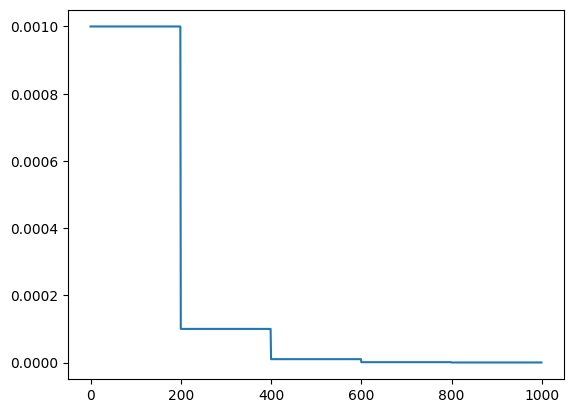

In [45]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

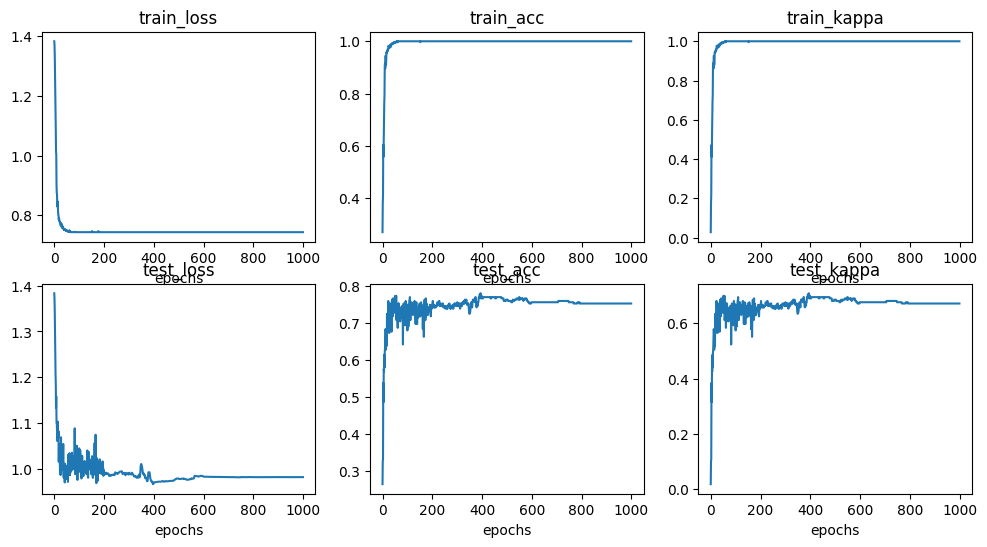

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

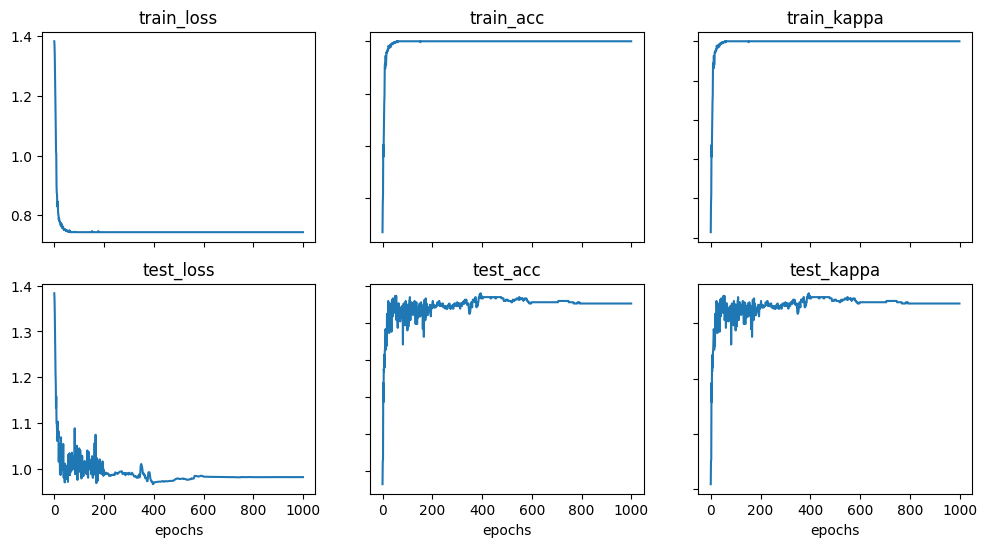

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()